#### Simple De Bruijn Graph implementation with Eulerian walk-finder

In [1]:
class DeBruijnGraph:
    ''' De Bruijn directed multigraph built from a collection of
        strings. User supplies strings and k-mer length k.  Nodes
        are k-1-mers.  An Edge corresponds to the k-mer that joins
        a left k-1-mer to a right k-1-mer. '''
 
    @staticmethod
    def chop(st, k):
        ''' Chop string into k-mers of given length '''
        for i in range(len(st)-(k-1)):
            yield (st[i:i+k], st[i:i+k-1], st[i+1:i+k])
    
    class Node:
        ''' Node representing a k-1 mer.  Keep track of # of
            incoming/outgoing edges so it's easy to check for
            balanced, semi-balanced. '''
        
        def __init__(self, km1mer):
            self.km1mer = km1mer
            self.nin = 0
            self.nout = 0
        
        def isSemiBalanced(self):
            return abs(self.nin - self.nout) == 1
        
        def isBalanced(self):
            return self.nin == self.nout
        
        def __hash__(self):
            return hash(self.km1mer)
        
        def __str__(self):
            return self.km1mer
    
    def __init__(self, strIter, k, circularize=False):
        ''' Build de Bruijn multigraph given string iterator and k-mer
            length k '''
        self.G = {}     # multimap from nodes to neighbors
        self.nodes = {} # maps k-1-mers to Node objects
        for st in strIter:
            if circularize:
                st += st[:k-1]
            for kmer, km1L, km1R in self.chop(st, k):
                nodeL, nodeR = None, None
                if km1L in self.nodes:
                    nodeL = self.nodes[km1L]
                else:
                    nodeL = self.nodes[km1L] = self.Node(km1L)
                if km1R in self.nodes:
                    nodeR = self.nodes[km1R]
                else:
                    nodeR = self.nodes[km1R] = self.Node(km1R)
                nodeL.nout += 1
                nodeR.nin += 1
                self.G.setdefault(nodeL, []).append(nodeR)
        # Iterate over nodes; tally # balanced, semi-balanced, neither
        self.nsemi, self.nbal, self.nneither = 0, 0, 0
        # Keep track of head and tail nodes in the case of a graph with
        # Eularian walk (not cycle)
        self.head, self.tail = None, None
        for node in iter(self.nodes.values()):
            if node.isBalanced():
                self.nbal += 1
            elif node.isSemiBalanced():
                if node.nin == node.nout + 1:
                    self.tail = node
                if node.nin == node.nout - 1:
                    self.head = node
                self.nsemi += 1
            else:
                self.nneither += 1
    
    def nnodes(self):
        ''' Return # nodes '''
        return len(self.nodes)
    
    def nedges(self):
        ''' Return # edges '''
        return len(self.G)
    
    def hasEulerianWalk(self):
        ''' Return true iff graph has Eulerian walk. '''
        return self.nneither == 0 and self.nsemi == 2
    
    def hasEulerianCycle(self):
        ''' Return true iff graph has Eulerian cycle. '''
        return self.nneither == 0 and self.nsemi == 0
    
    def isEulerian(self):
        ''' Return true iff graph has Eulerian walk or cycle '''
        # technically, if it has an Eulerian walk
        return self.hasEulerianWalk() or self.hasEulerianCycle()
    
    def eulerianWalkOrCycle(self):
        ''' Find and return sequence of nodes (represented by
            their k-1-mer labels) corresponding to Eulerian walk
            or cycle '''
        assert self.isEulerian()
        g = self.G
        if self.hasEulerianWalk():
            g = g.copy()
            g.setdefault(self.tail, []).append(self.head)
        # graph g has an Eulerian cycle
        tour = []
        src = next(iter(g.keys())) # pick arbitrary starting node
        
        def __visit(n):
            while len(g[n]) > 0:
                dst = g[n].pop()
                __visit(dst)
            tour.append(n)
        
        __visit(src)
        tour = tour[::-1][:-1] # reverse and then take all but last node
            
        if self.hasEulerianWalk():
            # Adjust node list so that it starts at head and ends at tail
            sti = tour.index(self.head)
            tour = tour[sti:] + tour[:sti]
        
        # Return node list
        return list(map(str, tour))

In [2]:
g = DeBruijnGraph(['AAABBBA'], k=3)

In [3]:
g.isEulerian(), g.hasEulerianWalk(), g.hasEulerianCycle()

(True, True, False)

In [4]:
# the figure we drew in class had 4 nodes
g.nnodes()

4

In [5]:
g.eulerianWalkOrCycle()

['AA', 'AB', 'BB', 'BB', 'BA', 'AA']

In [6]:
g = DeBruijnGraph(['AAABBBBA'], k=3) # Add 1 more B to the run of Bs

In [7]:
g.isEulerian(), g.hasEulerianWalk(), g.hasEulerianCycle()

(True, True, False)

In [8]:
# the figure we drew in class again had 4 nodes
g.nnodes()

4

In [9]:
g.eulerianWalkOrCycle()

['AA', 'AB', 'BB', 'BB', 'BB', 'BA', 'AA']

In [10]:
# circularize makes DeBruijnGraph treat string as circular,
# returning to left-hand side at extreme right end
g = DeBruijnGraph(['AAABBBBA'], k=3, circularize=True)

In [11]:
g.isEulerian(), g.hasEulerianWalk(), g.hasEulerianCycle()

(True, False, True)

In [12]:
g.eulerianWalkOrCycle()

['AA', 'AA', 'AB', 'BB', 'BB', 'BB', 'BA', 'AA']

In [13]:
DeBruijnGraph(["a_long_long_long_time"], 5).eulerianWalkOrCycle()

['a_lo',
 '_lon',
 'long',
 'ong_',
 'ng_l',
 'g_lo',
 '_lon',
 'long',
 'ong_',
 'ng_l',
 'g_lo',
 '_lon',
 'long',
 'ong_',
 'ng_t',
 'g_ti',
 '_tim',
 'time']

In [14]:
DeBruijnGraph(['a_long_long_long_time'], 5).eulerianWalkOrCycle().count('long')

3

In [15]:
# see if we can get correct reconstruction at k=4
walk = DeBruijnGraph(['to_every_thing_turn_turn_turn_there_is_a_season'], 4).eulerianWalkOrCycle()
walk[0] + ''.join(map(lambda x: x[-1], walk[1:]))

'to_every_thing_turn_turn_turn_there_is_a_season'

In [16]:
# that worked, but k=3 doesn't!  unresolvable repeat at k=3
walk = DeBruijnGraph(['to_every_thing_turn_turn_turn_there_is_a_season'], 3).eulerianWalkOrCycle()
walk[0] + ''.join(map(lambda x: x[-1], walk[1:]))

'to_every_turn_turn_thing_turn_there_is_a_season'

#### Visualizing the graph

We define a new Python class extending `DeBruijnGraph`, but adding a `to_dot` member function.  `to_dot` returns a Digraph object - a graph with directed edges.  See the [graphviz package user guide](http://graphviz.readthedocs.io/en/latest/manual.html) for more details on Digraph.  Jupyter is kind enough to render Digraphs into pretty pictures.

In [17]:
import graphviz

In [18]:
class DeBruijnGraph2(DeBruijnGraph):
    def to_dot(self, weights=False):
        """ Return string with graphviz representation.  If 'weights'
            is true, label edges corresponding to distinct k-1-mers
            with weights, instead of drawing separate edges for
            k-1-mer copies. """
        g = graphviz.Digraph(comment='DeBruijn graph')
        for node in iter(self.G.keys()):
            g.node(node.km1mer, node.km1mer)
        for src, dsts in iter(self.G.items()):
            if weights:
                weightmap = {}
                if weights:
                    for dst in dsts:
                        weightmap[dst] = weightmap.get(dst, 0) + 1
                for dst, v in weightmap.iteritems():
                    g.edge(src.km1mer, dst.km1mer, label=str(v))
            else:
                for dst in dsts:
                    g.edge(src.km1mer, dst.km1mer)
        return g

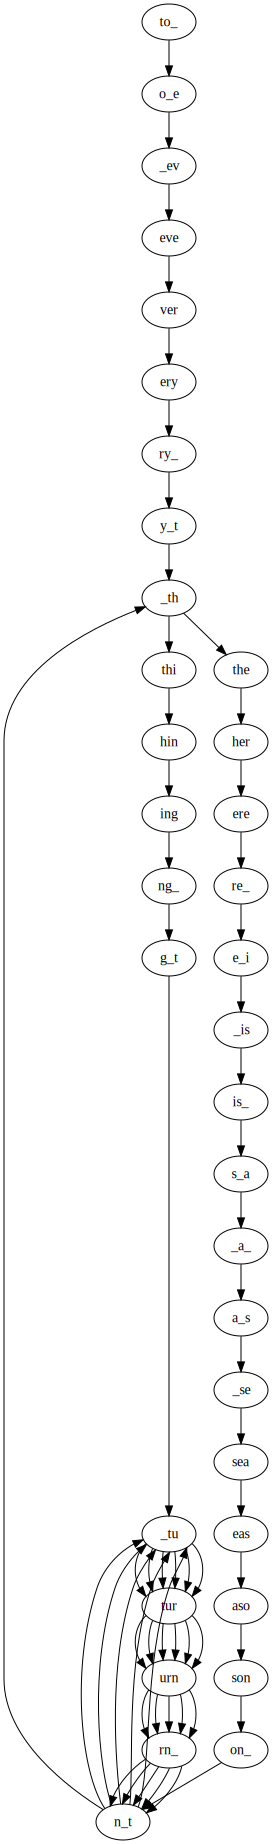

In [19]:
# sing along
DeBruijnGraph2(['to_every_thing_turn_turn_turn_there_is_a_season_turn_turn_turn'], 4).to_dot()

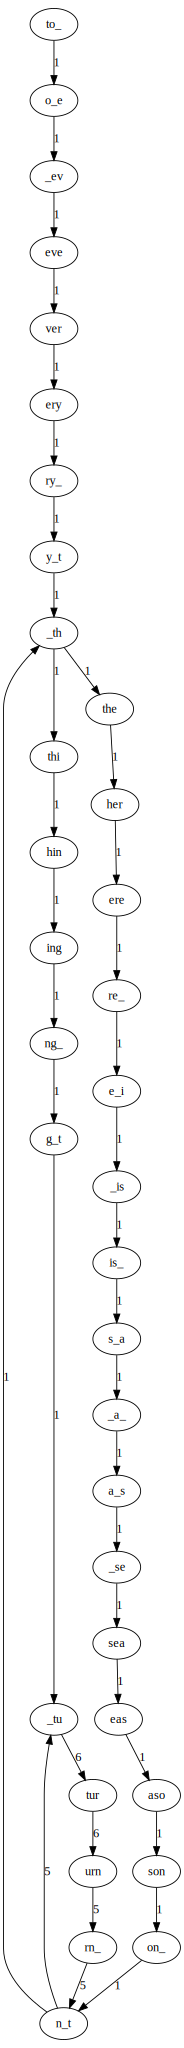

In [20]:
# now simplified with edge weights
DeBruijnGraph2(['to_every_thing_turn_turn_turn_there_is_a_season_turn_turn_turn'], 4).to_dot(True)